# 1- Geração de textos de Shakspeare

##1.1 - Introdução ao problema


Vamos treinar uma rede neural capaz de reproduzir o estilo de Shakspeare

## 1.2 - Importando e explorando os dados

In [2]:
#!pip install tensorflow

     -------------------------------------- 276.5/276.5 MB 7.1 MB/s eta 0:00:00
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached tensorflow_estimator-2.13.0-py2.py3-none-any.whl (440 kB)
     ---------------------------------------- 1.5/1.5 MB 47.6 MB/s eta 0:00:00
     ---------------------------------------- 4.2/4.2 MB 27.1 MB/s eta 0:00:00
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tensorboard-2.13.0-py3-none-any.whl (5.6 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached libclang-16.0.6-py2.py3-none-win_amd64.whl (24.4 MB)
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)
  Using cached protobuf-4.23.4-cp310-abi3-win_amd64.whl (422 kB)
  Using cached keras-2.13.1-py3-none-any.whl (1.7 MB)
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached tensorboard_data_serve

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
import keras

In [4]:
np.random.seed(123)
tf.random.set_seed(123)

In [5]:

link = "https://homl.info/shakespeare"
caminho = keras.utils.get_file("shakespeare.txt", link)
with open(caminho) as c:
    shakespeare_texto = c.read()



1115394/1115394 [==============================] - 0s 0us/step


In [6]:
print(shakespeare_texto[:300])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us


Vamos dar uma primeira olhada nas palavras mais frequentes no vocabulário de Shakespeare.

In [7]:
wordcloud = WordCloud().generate(shakespeare_texto)

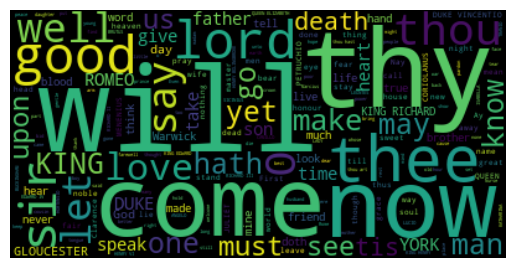

In [8]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Parece que Shakespeare gostava bastante do tema "Thy Lord".

Após fazer a carga dos dados de texto a partir do keras, vamos tratar os dados. Precisamos codificar cada caractere de texto como um número. Primeiro, vamos gerar tokens a partir do texto.

In [9]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True) #char_level = True garante a codificação no nível de caractere, e não no nível de palavras, que é o default.


In [10]:
tokenizer.fit_on_texts(shakespeare_texto)

In [11]:
max_id = len(tokenizer.word_index) # número de caracteres distintos
max_id

39

In [12]:
tamanho = tokenizer.document_count # número total de caracteres
tamanho

1115394

In [13]:
[texto_encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_texto])) - 1 #substraímos 1 para termos os IDs das letras a partir de 0


Para dividirmos nossa base em dados de treino e dados de teste, precisamos levar em consideração o fato que nossos dados são sequenciais.

In [15]:
train_index = tamanho * 95 // 100
dataset = tf.data.Dataset.from_tensor_slices(texto_encoded[:train_index])


Não podemos treinar a rede neural em todo o texto de uma única vez. Vamos criar pequenas fatias de texto, não sobrepostas, que irão alimentar a rede neural de forma adequada.

In [16]:
#gerando janelas de treino
n_steps = 100
window_length = n_steps + 1
dataset = dataset.window(window_length, shift=1, drop_remainder=True)


In [17]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [18]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows:(windows[:, :-1], windows[:, 1:]))

In [19]:
#como tenho apenas 39 caracteres distintos, vou usaro one hot encoder nos dados.
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))


In [20]:
dataset = dataset.prefetch(1)

In [21]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 39), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))>

In [23]:
model = keras.models.Sequential([
    keras.layers.GRU(16, return_sequences=True, input_shape=[ None,max_id],
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.GRU(16, return_sequences=True,
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=2)

Epoch 1/2
33111/33111 [==============================] - 1310s 39ms/step - loss: 2.2504
Epoch 2/2
33111/33111 [==============================] - 1028s 31ms/step - loss: 2.1840


Usando modelo para gerar textos "quase shakespeare".

In [27]:
def preprocess(texto):
    X = np.array(tokenizer.texts_to_sequences(texto)) - 1
    return tf.one_hot(X, max_id)

In [30]:
X_new = preprocess(["How are yo"])
Y_pred = np.argmax(model(X_new), axis=-1)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

'u'

In [31]:
tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()

array([[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 1,
        1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 2, 1, 1, 0]],
      dtype=int64)

In [35]:
def next_char(texto, level=1):
    X_new = preprocess([texto])
    y_proba = model(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / level
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [36]:
next_char("How are yo", level=1)

'u'

In [37]:
def complete_text(texto, n_chars=50, level=1):
    for _ in range(n_chars):
        texto += next_char(texto,level)
    return texto

In [41]:
print(complete_text("g", level=0.3))

ging the deat and the the love the king the she hav


In [42]:
print(complete_text("g", level=0.8))

gare the sand as;
sir will this leald your minioest


In [43]:
print(complete_text("g", level=1))

gaunt in for it theel get it, she meserour nous sha


O modelo treinado anteriormente inicia com pesos iguais a zero, e após todos os passos, joga fora esses pesos e começa novamente.
Podemos treinar um modelo que guarda os pesos obtidos anteriormente, embra isso exija um processamento maior dos dados antes de alimentarmos o modelo.

In [26]:
dataset = tf.data.Dataset.from_tensor_slices(texto_encoded[:train_index])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [44]:
batch_size = 32
encoded_parts = np.array_split(texto_encoded[:train_index], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [52]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     #dropout=0.2, recurrent_dropout=0.2,
                     dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [53]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [54]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=20,
                    callbacks=[ResetStatesCallback()])

Epoch 1/20
331/331 [==============================] - 35s 99ms/step - loss: 2.6051
Epoch 2/20
331/331 [==============================] - 34s 103ms/step - loss: 2.2242
Epoch 3/20
331/331 [==============================] - 33s 99ms/step - loss: 2.0981
Epoch 4/20
331/331 [==============================] - 33s 99ms/step - loss: 2.0236
Epoch 5/20
331/331 [==============================] - 33s 99ms/step - loss: 1.9749
Epoch 6/20
331/331 [==============================] - 33s 99ms/step - loss: 1.9389
Epoch 7/20
331/331 [==============================] - 33s 99ms/step - loss: 1.9120
Epoch 8/20
331/331 [==============================] - 33s 100ms/step - loss: 1.8920
Epoch 9/20
331/331 [==============================] - 33s 100ms/step - loss: 1.8738
Epoch 10/20
331/331 [==============================] - 39s 118ms/step - loss: 1.8607
Epoch 11/20
331/331 [==============================] - 38s 114ms/step - loss: 1.8481
Epoch 12/20
331/331 [==============================] - 33s 98ms/step - loss: 1.8

Vemos que a métrica de avaliação é bem melhor neste modelo dinâmico. O fato de guardar os pesos e de rodarmos mais épocas (por que o método é mais rápido de computar), faz com que o resultado seja melhor.

Agora vamos criaruma cópia estática domodelo, para que ele possa ser usado na geração de textos.

In [56]:
modelo_estatico = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [57]:
modelo_estatico.build(tf.TensorShape([None, None, max_id]))

In [58]:
modelo_estatico.set_weights(model.get_weights())
model = modelo_estatico

In [59]:
print(complete_text("g"))

glenger
is hole, and seam we sake my and every
sinc


In [60]:
print(complete_text("h"))

hy.
i he hath sould, the hone is we shoes such you;


Parece que o modelo que guarda os pesos traz um resultado melhor.

Esse modelo foi construído com relativamente poucas épocas de treinamento, pois o tempo de execução seria muito grande caso tentássemos mais épocas e mais ajustes em hiperparâmetros.

No entanto, conseguimos gerar os textos no estilo desejado com alguma semelhança.

